In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import imblearn
print(imblearn.__version__)

0.8.1


In [3]:
import pandas as pd
from sklearn.preprocessing import RobustScaler, OneHotEncoder
import random
import numpy as np
from scipy import stats
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, LSTM, SimpleRNN, TimeDistributed, Activation, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras import regularizers
from sklearn.utils import class_weight
from keras import backend as K
import statistics as st
from sklearn.preprocessing import StandardScaler
from numpy import genfromtxt
from tensorflow.keras.layers import BatchNormalization
from sklearn.preprocessing import FunctionTransformer
from imblearn.over_sampling import SMOTE
from numpy import dstack
from tensorflow.keras.utils import to_categorical
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import tensorflow as tf

scaler = StandardScaler()

In [4]:
X_files = ['subject_001_01__x.csv', 'subject_001_02__x.csv', 
           'subject_001_03__x.csv', 'subject_001_04__x.csv',
           'subject_001_06__x.csv',
           'subject_001_07__x.csv', 'subject_001_08__x.csv',
           'subject_002_01__x.csv', 'subject_002_02__x.csv',
           'subject_002_03__x.csv',
           'subject_002_05__x.csv', 'subject_003_01__x.csv',
           'subject_005_02__x.csv',
           'subject_005_03__x.csv', 'subject_006_01__x.csv',
           'subject_006_02__x.csv', 'subject_006_03__x.csv',
           'subject_007_01__x.csv',
           'subject_007_03__x.csv', 'subject_007_04__x.csv',
           'subject_008_01__x.csv']

X_test_files = ['subject_001_05__x.csv','subject_005_01__x.csv']
X_val_files = ['subject_007_02__x.csv','subject_002_04__x.csv']

y_files = ['subject_001_01__y.csv', 'subject_001_02__y.csv', 
           'subject_001_03__y.csv', 'subject_001_04__y.csv',
           'subject_001_06__y.csv',
           'subject_001_07__y.csv', 'subject_001_08__y.csv',
           'subject_002_01__y.csv', 'subject_002_02__y.csv',
           'subject_002_03__y.csv',
           'subject_002_05__y.csv', 'subject_003_01__y.csv',
           'subject_005_02__y.csv',
           'subject_005_03__y.csv', 'subject_006_01__y.csv',
           'subject_006_02__y.csv', 'subject_006_03__y.csv',
           'subject_007_01__y.csv',
           'subject_007_03__y.csv', 'subject_007_04__y.csv',
           'subject_008_01__y.csv']

y_test_files = ['subject_001_05__y.csv', 'subject_005_01__y.csv']
y_val_files = ['subject_007_02__y.csv',  'subject_002_04__y.csv']

# val_X = ['subject_003_02__x.csv', 'subject_003_03__x.csv',
#          'subject_004_01__x.csv', 'subject_004_02__x.csv']
# val_X_t = ['subject_003_02__x_time.csv', 'subject_003_03__x_time.csv',
#            'subject_004_01__x_time.csv', 'subject_004_02__x_time.csv']
# val_y = ['subject_003_02__y.csv', 'subject_003_03__y.csv',
#          'subject_004_01__y.csv', 'subject_004_02__y.csv']
# val_y_t = ['subject_003_02__y_time.csv', 'subject_003_03__y_time.csv',
#            'subject_004_01__y_time.csv', 'subject_004_02__y_time.csv']

# X_predict_files = ['subject_009_01__x.csv', 'subject_010_01__x.csv', 'subject_011_01__x.csv', 'subject_012_01__x.csv']

In [5]:
cd '/content/gdrive/MyDrive/data/'

/content/gdrive/MyDrive/data


In [6]:
final_x_train= []
final_y_train=[]
from collections import Counter

In [7]:
def most_frequent(List):
    occurence_count = Counter(List)
    return occurence_count.most_common(1)[0][0]

In [8]:
def mode(a, axis=0):
    scores = np.unique(np.ravel(a))       # get ALL unique values
    testshape = list(a.shape)
    testshape[axis] = 1
    oldmostfreq = np.zeros(testshape)
    oldcounts = np.zeros(testshape)

    for score in scores:
        template = (a == score)
        counts = np.expand_dims(np.sum(template, axis),axis)
        mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
        oldcounts = np.maximum(counts, oldcounts)
        oldmostfreq = mostfrequent

    return mostfrequent, oldcounts

In [9]:
## preprocessing for training data
for i in range(len(y_files)):
  X_df = pd.read_csv(X_files[i])
  y_df = pd.read_csv(y_files[i])
  a=[]
  for i in range(0, len(y_df)):
    a+=[y_df['0'][i]] * 4
  upsampled_df = pd.DataFrame(a)
  diff = X_df.shape[0] - upsampled_df.shape[0]
  X_df = X_df.iloc[:-diff,:]

  sc=StandardScaler()
  X_df=sc.fit_transform(X_df)

  x_arr=[]
  y_arr=[]

  for j in range(len(X_df)-30):
            window=30
            df = X_df[j].copy()
            df_len = len(df)
            x_arr.append(X_df[j:(j+window)]) 
            y_arr.append(mode(upsampled_df.iloc[j:(j+window)])[0])
  final_x_train.append(np.array(x_arr))
  final_y_train.append(np.array(y_arr).reshape(-1,1))

In [10]:
trainX, trainY = np.concatenate(final_x_train), np.concatenate(final_y_train)

In [11]:
trainX.shape, trainY.shape

((991762, 30, 6), (991762, 1))

In [12]:
t = pd.DataFrame(trainY)
t.value_counts()

0.0    734784
3.0    163013
2.0     53229
1.0     40736
dtype: int64

In [13]:
final_x_val = []
final_y_val = []

In [14]:
## preprocessing for val data
for i in range(len(y_val_files)):
  X_df = pd.read_csv(X_val_files[i])
  y_df = pd.read_csv(y_val_files[i])
  a=[]
  for i in range(0, len(y_df)):
    a+=[y_df['0'][i]] * 4
  upsampled_df = pd.DataFrame(a)
  diff = X_df.shape[0] - upsampled_df.shape[0]
  X_df = X_df.iloc[:-diff,:]

  sc=StandardScaler()
  X_df=sc.fit_transform(X_df)

  x_arr=[]
  y_arr=[]

  for j in range(len(X_df)-30):
            window=30
            df = X_df[j].copy()
            df_len = len(df)
            x_arr.append(X_df[j:(j+window)]) 
            y_arr.append(mode(upsampled_df.iloc[j:(j+window)])[0])
  final_x_val.append(np.array(x_arr))
  final_y_val.append(np.array(y_arr).reshape(-1,1))

In [15]:
valX, valY = np.concatenate(final_x_val), np.concatenate(final_y_val)

In [16]:
valX.shape, valY.shape

((98380, 30, 6), (98380, 1))

In [17]:
final_x_test = []
final_y_test =[]

In [18]:
## preprocessing for test data
for i in range(len(y_test_files)):
  X_df = pd.read_csv(X_test_files[i])
  y_df = pd.read_csv(y_test_files[i])
  a=[]
  for i in range(0, len(y_df)):
    a+=[y_df['0'][i]] * 4
  upsampled_df = pd.DataFrame(a)
  diff = X_df.shape[0] - upsampled_df.shape[0]
  X_df = X_df.iloc[:-diff,:]

  sc=StandardScaler()
  X_df=sc.fit_transform(X_df)

  x_arr=[]
  y_arr=[]

  for j in range(len(X_df)-30):
            window=30
            df = X_df[j].copy()
            df_len = len(df)
            x_arr.append(X_df[j:(j+window)]) 
            y_arr.append(mode(upsampled_df.iloc[j:(j+window)])[0])
  final_x_test.append(np.array(x_arr))
  final_y_test.append(np.array(y_arr).reshape(-1,1))

In [19]:
testX, testY = np.concatenate(final_x_test), np.concatenate(final_y_test)

In [20]:
testX.shape, testY.shape

((115132, 30, 6), (115132, 1))

In [21]:
from sklearn.utils import class_weight

label_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(trainY), y=trainY.ravel())
print(label_weights)
label_weights = {i:label_weights[i] for i in range(len(label_weights))} # Create dictionary
print(label_weights)

[0.33743318 6.08652052 4.65799658 1.52098606]
{0: 0.33743317764132047, 1: 6.08652052238806, 2: 4.657996580811212, 3: 1.520986056326796}


In [23]:
from tensorflow.keras import utils as np_utils
hot_y_train = np_utils.to_categorical(trainY)
hot_y_val = np_utils.to_categorical(valY)
hot_y_test = np_utils.to_categorical(testY)

In [24]:
timestep, features, n_outputs = trainX.shape[1], trainX.shape[2] , hot_y_train.shape[1]
model_LSTM = Sequential()
model_LSTM.add(InputLayer(input_shape=(timestep, features)))
model_LSTM.add(LSTM(units=125, activation='relu'))
model_LSTM.add(Dropout(0.5))
model_LSTM.add(Dense(units = 125, activation = 'relu'))
model_LSTM.add(Dense(n_outputs, activation='softmax')) # output layer
model_LSTM.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

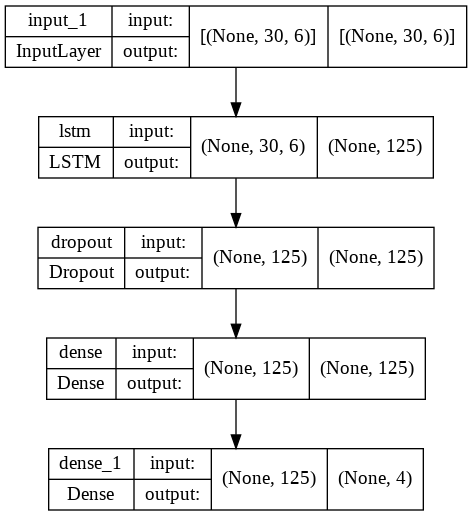

In [25]:
from keras.utils.vis_utils import plot_model
plot_model(model_LSTM, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [26]:
history = model_LSTM.fit(trainX, hot_y_train, epochs = 10, batch_size = 256,
                   validation_data = (valX, hot_y_val), class_weight = label_weights,
                   verbose = 1, shuffle = True)

Epoch 1/10
3875/3875 [==============================] - 459s 118ms/step - loss: 0.3227 - accuracy: 0.7928 - val_loss: 0.2727 - val_accuracy: 0.9066
Epoch 2/10
3875/3875 [==============================] - 467s 120ms/step - loss: 0.1841 - accuracy: 0.8891 - val_loss: 0.2875 - val_accuracy: 0.8982
Epoch 3/10
3875/3875 [==============================] - 471s 122ms/step - loss: 0.1412 - accuracy: 0.9123 - val_loss: 0.2724 - val_accuracy: 0.8995
Epoch 4/10
3875/3875 [==============================] - 473s 122ms/step - loss: 0.1268 - accuracy: 0.9212 - val_loss: 0.2135 - val_accuracy: 0.9282
Epoch 5/10
3875/3875 [==============================] - 466s 120ms/step - loss: 0.1043 - accuracy: 0.9323 - val_loss: 0.1966 - val_accuracy: 0.9325
Epoch 6/10
3875/3875 [==============================] - 457s 118ms/step - loss: 0.0965 - accuracy: 0.9385 - val_loss: 0.2454 - val_accuracy: 0.9099
Epoch 7/10
3875/3875 [==============================] - 463s 119ms/step - loss: 0.0850 - accuracy: 0.9450 - val_

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


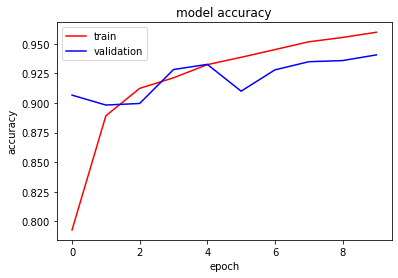

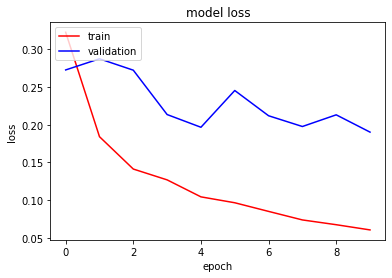

In [27]:
print(history.history.keys())
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['accuracy'], color='red')
plt.plot(history.history['val_accuracy'], color='blue')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'], color='red')
plt.plot(history.history['val_loss'], color='blue')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [28]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report

y_pred = model_LSTM.predict(testX, batch_size = 256, verbose = 1)
y_test_bool = np.argmax(y_pred, axis = 1)
print(classification_report(testY, y_test_bool))

450/450 [==============================] - 20s 44ms/step
              precision    recall  f1-score   support

         0.0       0.98      0.91      0.94     90937
         1.0       0.80      0.98      0.88      6247
         2.0       0.86      0.98      0.91      9171
         3.0       0.59      0.83      0.69      8777

    accuracy                           0.91    115132
   macro avg       0.81      0.92      0.86    115132
weighted avg       0.93      0.91      0.92    115132



In [29]:
print(confusion_matrix(testY, y_test_bool))

[[82845  1551  1453  5088]
 [  103  6131     5     8]
 [  216     0  8955     0]
 [ 1453     8    26  7290]]


In [30]:
cd ..

/content/gdrive/MyDrive


In [31]:
cd 'TestData'

[Errno 2] No such file or directory: 'TestData'
/content/gdrive/MyDrive


In [32]:
input_data = pd.read_csv('subject_009_01__x.csv')
df=sc.fit_transform(input_data)
y_frame = pd.read_csv('subject_009_01__y_time.csv')
addl_rows = y_frame.shape[0] * 4 - df.shape[0] + 30
addl_rows_df = pd.DataFrame(df[-addl_rows:])
df = pd.DataFrame(df)
df = df.append(addl_rows_df)
X_values = []
for i in range(0, len(df) - 30, 1):
    value = df.iloc[i:(i + 30)].values
    X_values.append(value)
X_test = np.array(X_values)
y_test = model_LSTM.predict(X_test, batch_size = 64, verbose = 1)
y_test_class = np.argmax(y_test, axis = 1)
output_actual = []
for i in range(0, y_test_class.shape[0], 4):
    a = list(y_test_class[i:i + 4])
    output_actual.append(max(a, key = a.count))
y_actual = np.array(output_actual)
print(y_actual.size)
y_series = pd.Series(y_actual)

FileNotFoundError: ignored

In [ ]:
from google.colab import files
y_series.to_csv('subject_009_01__y_prediction.csv') 
files.download('subject_009_01__y_prediction.csv')
y_series.value_counts()

In [ ]:
input_data = pd.read_csv('subject_010_01__x.csv')
df=sc.fit_transform(input_data)
y_frame = pd.read_csv('subject_010_01__y_time.csv')
addl_rows = y_frame.shape[0] * 4 - df.shape[0] + 30
addl_rows_df = pd.DataFrame(df[-addl_rows:])
df = pd.DataFrame(df)
df = df.append(addl_rows_df)
X_values = []
for i in range(0, len(df) - 30, 1):
    value = df.iloc[i:(i + 30)].values
    X_values.append(value)
X_test = np.array(X_values)
y_test = model_LSTM.predict(X_test, batch_size = 64, verbose = 1)
y_test_class = np.argmax(y_test, axis = 1)
output_actual = []
for i in range(0, y_test_class.shape[0], 4):
    a = list(y_test_bool[i:i + 4])
    output_actual.append(max(a, key = a.count))
y_actual = np.array(output_actual)
print(y_actual.size)
y_series = pd.Series(y_actual)

In [ ]:
y_series.to_csv('subject_010_01__y_prediction.csv') 
files.download('subject_010_01__y_prediction.csv')
y_series.value_counts()

In [ ]:
input_data = pd.read_csv('subject_011_01__x.csv')
df=sc.fit_transform(input_data)
y_frame = pd.read_csv('subject_011_01__y_time.csv')
addl_rows = y_frame.shape[0] * 4 - df.shape[0] + 30
addl_rows_df = pd.DataFrame(df[-addl_rows:])
df = pd.DataFrame(df)
df = df.append(addl_rows_df)
X_values = []
for i in range(0, len(df) - 30, 1):
    value = df.iloc[i:(i + 30)].values
    X_values.append(value)
X_test = np.array(X_values)
y_test = model_LSTM.predict(X_test, batch_size = 64, verbose = 1)
y_test_class = np.argmax(y_test, axis = 1)
output_actual = []
for i in range(0, y_test_class.shape[0], 4):
    a = list(y_test_class[i:i + 4])
    output_actual.append(max(a, key = a.count))
y_actual = np.array(output_actual)
print(y_actual.size)
y_series = pd.Series(y_actual)

In [ ]:
y_series.to_csv('subject_011_01__y_prediction.csv') 
files.download('subject_011_01__y_prediction.csv')
y_series.value_counts()

In [ ]:
input_data = pd.read_csv('subject_012_01__x.csv')
df=sc.fit_transform(input_data)
y_frame = pd.read_csv('subject_012_01__y_time.csv')
addl_rows = y_frame.shape[0] * 4 - df.shape[0] + 30
addl_rows_df = pd.DataFrame(df[-addl_rows:])
df = pd.DataFrame(df)
df = df.append(addl_rows_df)
X_values = []
for i in range(0, len(df) - 30, 1):
    value = df.iloc[i:(i + 30)].values
    X_values.append(value)
X_test = np.array(X_values)
y_test = model_LSTM.predict(X_test, batch_size = 64, verbose = 1)
y_test_class = np.argmax(y_test, axis = 1)
output_actual = []
for i in range(0, y_test_class.shape[0], 4):
    a = list(y_test_class[i:i + 4])
    output_actual.append(max(a, key = a.count))
y_actual = np.array(output_actual)
print(y_actual.size)
y_series = pd.Series(y_actual)

In [ ]:
y_series.to_csv('subject_012_01__y_prediction.csv') 
files.download('subject_012_01__y_prediction.csv')
y_series.value_counts()

In [ ]:
input_data = pd.read_csv('subject_012_01__x.csv')
df=sc.fit_transform(input_data)
y_frame = pd.read_csv('subject_012_01__y_time.csv')
addl = y_frame.shape[0] * 4 - df.shape[0] + 30
addl_df = pd.DataFrame(df[-addl:])
df = pd.DataFrame(df)
df = df.append(addl_df)
X_values = []
for i in range(0, len(df) - 30, 1):
    value = df.iloc[i:(i + 30)].values
    X_values.append(value)
X_test = np.array(X_values)
y_test = model_LSTM.predict(X_test, batch_size = 64, verbose = 1)
y_test_bool = np.argmax(y_test, axis = 1)
output_actual = []
for i in range(0, y_test_bool.shape[0], 4):
    a = list(y_test_bool[i:i + 4])
    output_actual.append(max(a, key = a.count))
y_actual = np.array(output_actual)
print(y_actual.size)
y_series = pd.Series(y_actual)